In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
# Define folder that contains the preprocessed dhg dataset
DHG_IN_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Preprocessed"
# Define file to export
META_DATA_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Preprocessed/Metadata.csv"

In [3]:
#
meta_data = pd.read_csv(META_DATA_PATH)
#
meta_data = meta_data[meta_data.file_name.str.contains('s')]

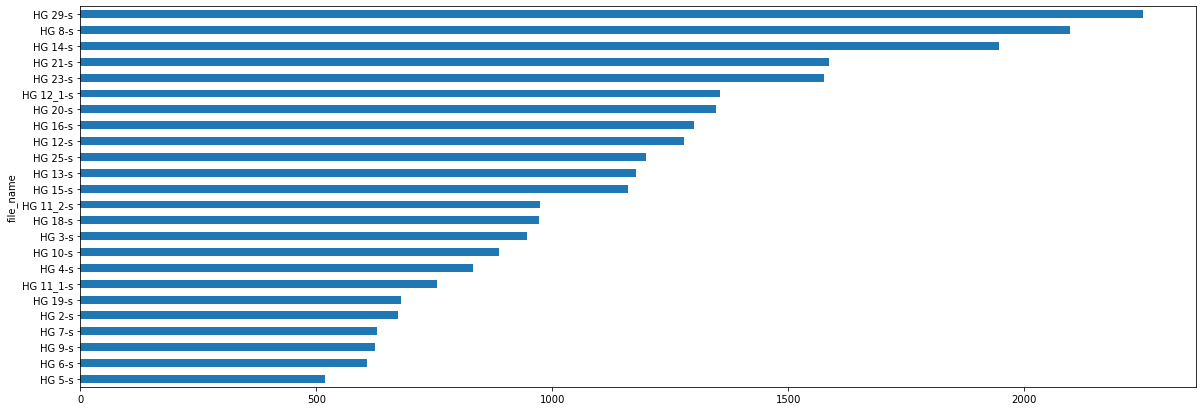

In [4]:
plt.figure(figsize=(20,7))
meta_data.groupby(['file_name']).size().sort_values().plot(kind="barh")
plt.show()

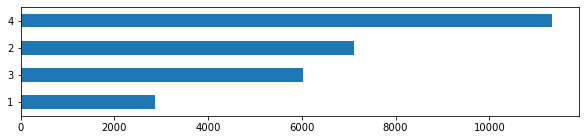

In [5]:
plt.figure(figsize=(10,2))
meta_data.who_grade.astype(str).value_counts().sort_values().plot(kind="barh")
plt.show()

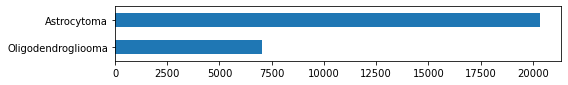

In [6]:
plt.figure(figsize=(8,1))
meta_data.histology.value_counts().sort_values().plot(kind="barh")
plt.show()

In [9]:
exclude_sample = meta_data.file_name[0]
exclude_sample

'HG 10-s'

In [10]:
meta_data_train = meta_data[meta_data.file_name != exclude_sample]
meta_data_train.shape

(26483, 7)

In [11]:
meta_data_test = meta_data[meta_data.file_name != exclude_sample]
meta_data_test.shape

(26483, 7)

In [13]:
parsers = { file_name: ImzMLParser(os.path.join(DHG_IN_PATH, f"{file_name}.imzML")) for file_name in meta_data.file_name.unique()}

In [14]:
class AutoencoderDataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, df, parsers, batch_size=32,
               dim=(92000,), n_channels=1, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.df = df
    self.parsers = parsers
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.df) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    batch_df = self.df[index*self.batch_size:(index+1)*self.batch_size]
    # Generate data
    X, y = self.__data_generation(batch_df)
    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    if self.shuffle == True:
        self.df = self.df.sample(frac=1).reset_index(drop=True)

  def __data_generation(self, batch_df):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, * self.dim))
    y = np.empty((self.batch_size, * self.dim))
    # Generate data
    for i, (_, row) in enumerate(batch_df.iterrows()):
      # get spectra
      _, spectra = self.parsers[row.file_name].getspectrum(row.idx)
      # Store sample
      X[i,] = spectra
      # Store class
      y[i] = spectra
    return X, y

2022-04-22 18:16:36.582678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:16:36.582742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
# Parameters
params = {'dim': (92000,),
          'batch_size': 128,
          'n_channels': 1,
          'shuffle': True,
          "parsers": parsers
         }

# Generators
meta_data_train_split, meta_data_val_split = train_test_split(meta_data_train, test_size=0.2)
training_generator = AutoencoderDataGenerator(meta_data_train_split, **params)
validation_generator = AutoencoderDataGenerator(meta_data_val_split, **params)

In [20]:
# 
input_spectra = keras.Input(shape=(92000,))
encoded = layers.Dense(512, activation='relu')(input_spectra)
encoded = layers.Dense(10, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(encoded)
decoded = layers.Dense(92000, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_spectra, decoded)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [21]:
autoencoder.fit(x=training_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
165/165 [==============================] - 462s 3s/step - loss: 10.9031 - val_loss: 10.7600
Epoch 2/10
165/165 [==============================] - 514s 3s/step - loss: 10.7585 - val_loss: 10.7584
Epoch 3/10
 21/165 [==>...........................] - ETA: 5:40 - loss: 10.7570

KeyboardInterrupt: 